### Problem 1

In [1]:
import qflib as qf
import numpy as np
import matplotlib.pyplot as plt
qf.version()

'0.9.0-debug'

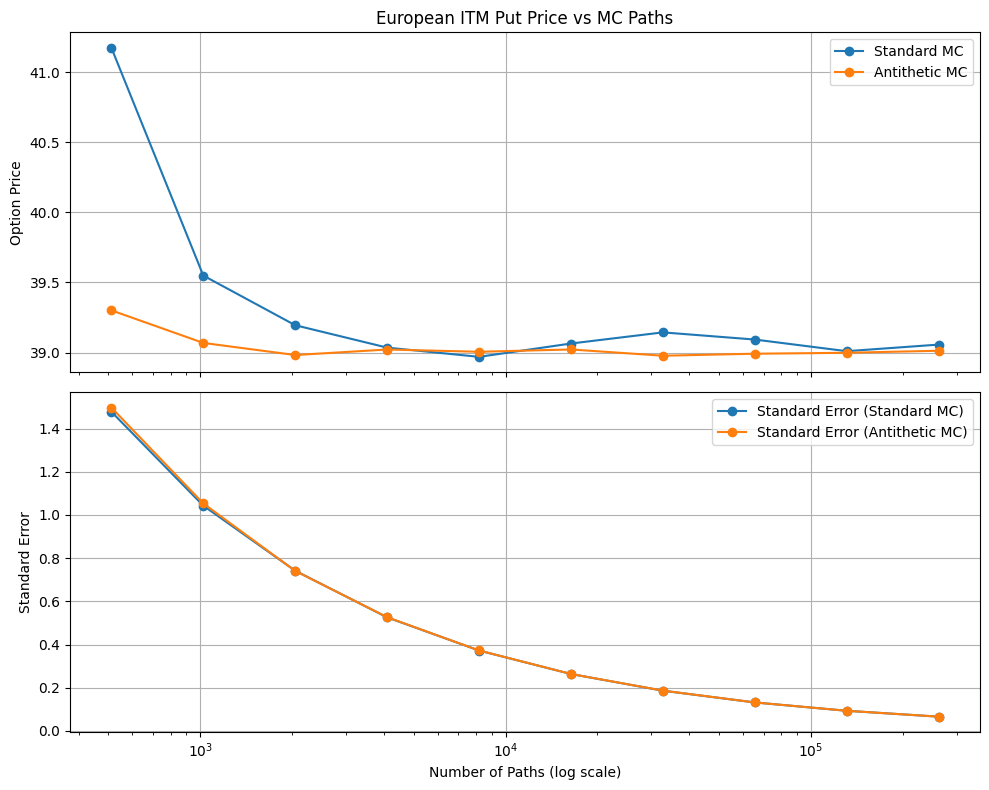

In [2]:
spot = 100.0
strike = 120.0
volatility = 0.60
div_yield = 0.0
maturity = 2.0
timetoexp = maturity

spot_rate_data = {
    1/12: 0.0100,
    1/4:  0.0200,
    1/2:  0.0300,
    3/4:  0.0350,
    1.0:  0.0400,
    2.0:  0.0480,
    3.0:  0.0530,
    5.0:  0.0600
}

maturities = np.array(list(spot_rate_data.keys()))
spot_rates = np.array(list(spot_rate_data.values()))
ycname = "yc1"
qf.ycCreate(ycname, maturities, spot_rates, valtype=0)

mcpaths = [2**i for i in range(9, 19)]

def run_mc(control):
    prices = []
    errors = []
    mcparams = {
        "URNGTYPE": "MT19937",
        "PATHGENTYPE": "EULER",
        "CONTROLVARTYPE": control
    }
    for n in mcpaths:
        result = qf.euroBSMC(
            payofftype=-1,
            strike=strike,
            timetoexp=timetoexp,
            spot=spot,
            discountcrv=ycname,
            divyield=div_yield,
            volatility=volatility,
            mcparams=mcparams,
            npaths=n
        )
        prices.append(result["Mean"])
        errors.append(result["StdErr"])
    return prices, errors

plain_prices, plain_errors = run_mc("NONE")
anti_prices, anti_errors = run_mc("ANTITHETIC")

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(mcpaths, plain_prices, marker='o', label='Standard MC')
axs[0].plot(mcpaths, anti_prices, marker='o', label='Antithetic MC')
axs[0].set_ylabel("Option Price")
axs[0].set_title("European ITM Put Price vs MC Paths")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(mcpaths, plain_errors, marker='o', label='Standard Error (Standard MC)')
axs[1].plot(mcpaths, anti_errors, marker='o', label='Standard Error (Antithetic MC)')
axs[1].set_xlabel("Number of Paths (log scale)")
axs[1].set_ylabel("Standard Error")
axs[1].set_xscale("log")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Problem 2

In [3]:
spot = 100.0
n_assets = 3
spots = np.full(n_assets, spot)

volatilities = np.full(n_assets, 0.30)
divyields = np.zeros(n_assets)

correlmat = np.full((n_assets, n_assets), 0.5)
np.fill_diagonal(correlmat, 1.0)

spot_rate_data = {
    1/12: 0.0100,
    1/4:  0.0200,
    1/2:  0.0300,
    3/4:  0.0350,
    1.0:  0.0400,
    2.0:  0.0480,
    3.0:  0.0530,
    5.0:  0.0600
}
maturities = np.array(list(spot_rate_data.keys()))
spot_rates = np.array(list(spot_rate_data.values()))
ycname = "yc1"
qf.ycCreate(ycname, maturities, spot_rates, valtype=0)

strike = 1.0  
timeToFix = 1.0
timeToExp = 2.0
npaths = 100_000

mcparams = {
    "URNGTYPE": "MT19937",
    "PATHGENTYPE": "EULER",
    "CONTROLVARTYPE": "NONE"
}

call_result = qf.worstofDigiBSMC(1, strike, timeToFix, timeToExp, spots, ycname,
                                 divyields, volatilities, correlmat, mcparams, npaths)
put_result = qf.worstofDigiBSMC(-1, strike, timeToFix, timeToExp, spots, ycname,
                                divyields, volatilities, correlmat, mcparams, npaths)

from math import exp
spotrate = 0.0480  
discount_factor = exp(-spotrate * timeToExp)

print("Worst-of Digital Call Price: {:.6f}".format(call_result["Mean"]))
print("Worst-of Digital Put  Price: {:.6f}".format(put_result["Mean"]))
print("Sum (Call + Put):            {:.6f}".format(call_result["Mean"] + put_result["Mean"]))
print("Discount Factor D(T2):       {:.6f}".format(discount_factor))

Worst-of Digital Call Price: 0.239326
Worst-of Digital Put  Price: 0.669138
Sum (Call + Put):            0.908464
Discount Factor D(T2):       0.908464
